In [1]:
import sys
sys.path.append("/home/an0104ro/ece-scm-coupling")
sys.path.append("/home/an0104ro/aoscm_ice_helpers")
%matplotlib inline

import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, ListedColormap

from AOSCMcoupling.files import OIFSPreprocessor, NEMOPreprocessor, OASISPreprocessor
from AOSCMcoupling.convergence_checker import vector_norm, relative_error, relative_criterion

plt.style.use('rc.mplstyle')
plotting_output_dir = Path(f"Plots_for_Thesis")
plotting_output_dir.mkdir(exist_ok=True, parents = True)

In [2]:
start_date = pd.Timestamp("2023-05-28")
oifs_preprocessor = OIFSPreprocessor(
    start_date, np.timedelta64(-0, "h")
)
nemo_preprocessor = NEMOPreprocessor(
    start_date, np.timedelta64(-0, "h")
)

oasis_preprocessor = OASISPreprocessor(
    start_date, np.timedelta64(-0, "h")
)

In [3]:
target_latitudes = [80.0, 81.0]
target_longitudes = [1.0, 2.5, 4.0, 5.5, 7.0]
lon_lats = [(1.0, 79.0), (2.5, 79.0)] + [
    (lon, lat) for lon in target_longitudes for lat in target_latitudes
]

ece4_dir_paths  = [Path(f"output_control_experiment_50_iter/lon_{lon}_lat_{lat}/SWR") for lon, lat in lon_lats]

In [4]:
# Initial sea ice concentrations
ece4_dir_pathsP  = [Path(f"output_control_experiment_50_iter/lon_{lon}_lat_{lat}/RPP/") for lon, lat in lon_lats]
Init_ice = [
    xr.open_mfdataset(
          f"{ece4_dir}/Ice_initialization.nc"
    )
    for ece4_dir in ece4_dir_pathsP 
]

# sort locations by initial concentration
init_conc = [ds['a_i'].values[0,0,0] for ds in Init_ice]
sorted_by_concentration = sorted(zip(init_conc, lon_lats), key=lambda x: x)
concentrations_sorted, lon_lats_sorted_by_conc = zip(*sorted_by_concentration)
concentrations_sorted

(0.09979535639286041,
 0.21305273473262787,
 0.652911901473999,
 0.7192678451538086,
 0.8668397665023804,
 0.8911898732185364,
 0.8942373394966125,
 0.9339291453361511,
 0.9368117451667786,
 0.9439182281494141,
 0.9501858949661255,
 0.951397716999054)

### Convergence plots

In [5]:
coupling_vars_with_names_r = {
    #"SSTSST": "Sea Surface Temperature [K]",
    #"TauX_i": "Zonal Wind Stress Ice [$N m^{{-2}}$]",
    #"TauX_o": "Zonal Wind Stress Ocean [$N m^{{-2}}$]",
    #"TauY_i": "Meridional Wind Stress Ice [$N m^{{-2}}$]",
    #"TauY_o": "Meridional Wind Stress Ocean",
    "Qs_i": "Solar Heat Flux Ice [$W m^{{-2}}$]",
    #"Qs_mix": "Solar Heat Flux Mix [$W m^{{-2}}$]",
    #"Qns_mix": "Nonsolar Heat Flux Mix[$W m^{{-2}}$]",
    #"Qns_i": "Nonsolar Heat Flux Ice[$W m^{{-2}}$]",
    #"Evap_i": "Ice Evaporation",
    #"Evap_t": "Total Evaporation",
    "Precip_s": "Solid Precipitation",
    #"Precip_l": "Liquid Precipitation",
    #"dQns_dT": "Temperature Sensibility",
    "AlbIce": "Ice albedo",
    "TepIce": "Ice Surface Temperature", 
    #"IceFrc": "Ice fraction", 
    "IceTck": "Ice thickness", 
    "SnwTck": "Snow Thickness", 
}

latex_coup_variables = [r"$Q_{sr}^{ice}$", r"$P^s$", r"$\alpha^{ice}$", r"$IST$", r"$h^{ice}$", r"$h^{snw}$"] 

In [6]:
# target location and other parameter
lon_lats = lon_lats_sorted_by_conc
conv_variables = list(coupling_vars_with_names_r.keys())
ece4_dir = Path("/home/an0104ro/experiments_reanalysis/output_control_experiment_50_iter/")
tolerance = 10**-3
max_iters = 30 
exp_id = 'RSW'

# Custom colormap
colors = list(plt.cm.Greys(np.linspace(0, 1, 256)))
custom_cmap = ListedColormap(colors)

In [7]:
# compute relative errors for locations and variables at each iteration
global_min = 10000
global_max = -10000
relative_errors_dict = {}

for conv_variable in conv_variables:
    relative_errors = np.zeros((len(lon_lats), max_iters - 1))

    for j, (lon, lat) in enumerate(lon_lats):
        dir = ece4_dir / f"lon_{lon}_lat_{lat}/SWR"
        preprocessor = OASISPreprocessor()
        schwarz_dir_ref = dir / f"{exp_id}_{1}"
        coupling_file_reference = next(schwarz_dir_ref.glob(f"*{conv_variable}*.nc"))
        reference = xr.open_mfdataset(coupling_file_reference, preprocess=preprocessor.preprocess)

        schwarz_dir_iter = dir / f"{exp_id}_1"
        for iter in range(1, max_iters):
            schwarz_dir_next_iter = dir / f"{exp_id}_{iter + 1}"
            coupling_file_iterate = next(schwarz_dir_iter.glob(f"*{conv_variable}*.nc"))
            coupling_file_next_iterate = next(schwarz_dir_next_iter.glob(f"*{conv_variable}*.nc"))

            iterate = xr.open_mfdataset(coupling_file_iterate, preprocess=preprocessor.preprocess)
            next_iterate = xr.open_mfdataset(coupling_file_next_iterate, preprocess=preprocessor.preprocess)

            # Compute relative error for this iteration and location
            relative_errors[j, iter - 1] = relative_error(
                iterate, next_iterate, reference, ord=np.inf
            ).values[0]

            schwarz_dir_iter = schwarz_dir_next_iter

    # look for global min and global max
        
    global global_min, global_max
    global_min = min(global_min, relative_errors[relative_errors > 0].min())
    global_max = max(global_max, relative_errors.max())

    relative_errors_dict[conv_variable] = relative_errors

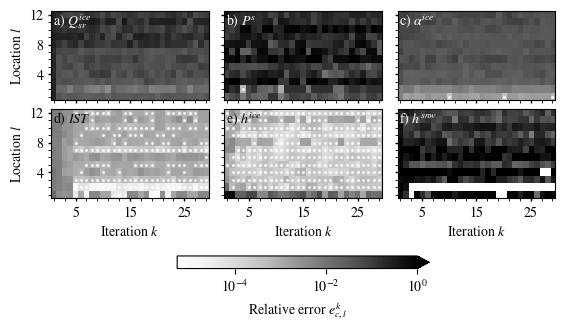

In [8]:
#Plot convergence plots
letters = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)", "i)", "j)", "k)", "l)"]

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(6, 4), sharex = True, sharey = True)
axs = axs.flatten()

for i, conv_variable in enumerate(conv_variables):
    relative_errors = relative_errors_dict[conv_variable]
    ax = axs[i]
    c = ax.imshow(
        relative_errors,
        aspect="auto",
        cmap=custom_cmap,
        origin="lower",
        extent=[1, max_iters, 0, len(lon_lats)],
        norm=LogNorm(vmin=global_min, vmax=1),
    )
    ax.grid(False)
    if i == 3 or i == 4: 
        ax.text(0.01, 0.99, letters[i] +' ' +latex_coup_variables[i], ha='left', va='top', transform=ax.transAxes) # letters[i] +' ' +
    else: 
        ax.text(0.01, 0.99, letters[i] +' ' +latex_coup_variables[i], color = "w", ha='left', va='top', transform=ax.transAxes) # letters[i] +' ' +latex_coup_variables[i],
    if  i == 3 or i == 4 or i == 5:
        ax.set_xlabel(r"Iteration $k$")
    if i%3 == 0:
        ax.set_ylabel(r"Location $l$")

    num_rows = relative_errors.shape[0]
    num_cols = relative_errors.shape[1]
   
    ytick_positions = np.arange(0.5, num_rows, 3) 
    xtick_positions = [5.5, 15.5, 25.5] 
    ytick_positions = [3.5, 7.5, 11.5]
    
    ax.set_yticks(ytick_positions)
    ax.set_yticklabels((np.array(ytick_positions) + 0.5).astype(int))
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels((np.array(xtick_positions) - 0.5).astype(int))


    # Relative errors below tolerance = white
    for j in range(len(lon_lats)):
        for k in range(max_iters - 1):
            if relative_errors[j, k] < tolerance:
                ax.plot(k + 1 + 0.5, j + 0.5, '.', markersize=2, color = 'w') 
    
    ax.minorticks_on()
    ax.tick_params(axis='both', direction='out', length=2, width=1)

fig.subplots_adjust(hspace=0.1,wspace=0.1)
fig.colorbar(c, ax=axs, orientation="horizontal", label=r"Relative error $e_{c,l}^k$", shrink=0.5, pad=0.2, extend = "max")
fig.savefig(plotting_output_dir/"sec2_conv_plots.pdf", bbox_inches='tight')

plt.show()


### Bar plot relative errors

In [9]:
# Define the intervalls for bar plot
ranges = {
    "< 0.001": lambda x: x <= 0.001,
    "0.001 - 0.01": lambda x: 0.001 < x <= 0.01,
    "0.01 - 0.1": lambda x: 0.01 < x <= 0.1,
    "0.1 - 1": lambda x: 0.1 < x <= 1,
    "> 1": lambda x: x > 1,
}

percentages_dict = {}

# Compute percentages
for variable, errors_2d in relative_errors_dict.items():

    errors_flat = np.array(errors_2d).flatten()
    total_iterations = len(errors_flat)
    percentages = {}
    for range_label, condition in ranges.items():
        count = sum(1 for error in errors_flat if condition(error))
        percentages[range_label] = (count / total_iterations) * 100
    percentages_dict[variable] = percentages

# Display results
for variable, percentages in percentages_dict.items():
    print(f"{variable}:")
    for range_label, percentage in percentages.items():
        print(f"  {range_label}: {percentage:.2f}%")

Qs_i:
  < 0.001: 0.00%
  0.001 - 0.01: 3.74%
  0.01 - 0.1: 63.51%
  0.1 - 1: 32.76%
  > 1: 0.00%
Precip_s:
  < 0.001: 0.29%
  0.001 - 0.01: 1.15%
  0.01 - 0.1: 25.57%
  0.1 - 1: 69.54%
  > 1: 3.45%
AlbIce:
  < 0.001: 0.86%
  0.001 - 0.01: 15.23%
  0.01 - 0.1: 83.91%
  0.1 - 1: 0.00%
  > 1: 0.00%
TepIce:
  < 0.001: 47.41%
  0.001 - 0.01: 52.30%
  0.01 - 0.1: 0.29%
  0.1 - 1: 0.00%
  > 1: 0.00%
IceTck:
  < 0.001: 80.46%
  0.001 - 0.01: 13.22%
  0.01 - 0.1: 5.75%
  0.1 - 1: 0.57%
  > 1: 0.00%
SnwTck:
  < 0.001: 9.20%
  0.001 - 0.01: 0.57%
  0.01 - 0.1: 25.29%
  0.1 - 1: 47.41%
  > 1: 17.53%


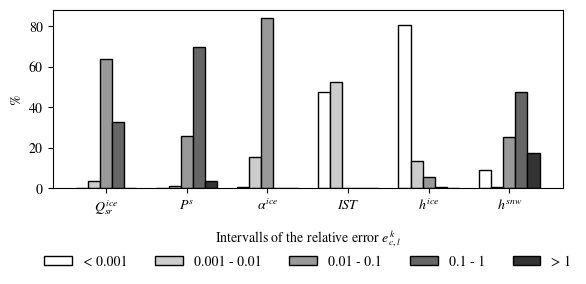

In [10]:
# Bar plot
range_labels = list(ranges.keys())
variables = list(percentages_dict.keys())
data = {label: [percentages_dict[var].get(label, 0) for var in variables] for label in range_labels}

# Generate shades of gray for the bars
num_ranges = len(range_labels)
grayscale_colors = np.flip([str(0.2 + 0.8 * i / (num_ranges - 1)) for i in range(num_ranges)])  # Shades between 0.2 and 1 (dark to light)

# Plotting
fig, ax = plt.subplots(figsize=(6, 3))

x = np.arange(len(variables))  
width = 0.15  
offset = -width * (num_ranges - 1) / 2  

for i, (range_label, values) in enumerate(data.items()):
    ax.bar(
        x + offset + i * width,  
        values, 
        width,  
        label=range_label,  
        color=grayscale_colors[i],  
        edgecolor="black"  
    )

# Customizing the plot
ax.set_xticks(x)
ax.set_xticklabels(latex_coup_variables)
ax.set_ylabel("%")

ax.legend(title=r"Intervalls of the relative error $e_{c,l}^k$",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),  
    ncol=5,  
    frameon=False)
ax.grid(False)

plt.tight_layout()
fig.savefig(plotting_output_dir/"sec2_bar_chart.pdf")
plt.show()

### $Q_{sr}^{ice}$

In [11]:
N_iterates = 30
lon_lats = [(4.0, 81.0)]

ece4_dir_paths  = [Path(f"output_control_experiment_50_iter/lon_{lon}_lat_{lat}/SWR") for lon, lat in lon_lats]
def generate_sip_list(n):
    return [f"RSW_{i}" for i in range(1, n+1)]
exp_ids = generate_sip_list(N_iterates)
exp_ids 
ece4_dir_paths 


Qs_ice_A_grids_ece4 = [[
    xr.open_mfdataset(
        f"{ece4_dir}/{exp_id}/A_Qs_ice*.nc", preprocess=oasis_preprocessor.preprocess
    )
    for exp_id in exp_ids
]for ece4_dir in ece4_dir_paths]

/home/an0104ro/ece4/lib/python3.11/site-packages/AOSCMcoupling/files.py:240: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=self.origin + time_data + self.time_shift)
/home/an0104ro/ece4/lib/python3.11/site-packages/AOSCMcoupling/files.py:240: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta6

In [12]:
letterarray = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

d_alpha = 1/N_iterates
color = "black"
#labels = ["parallel", "atm-first", "oce-first", "converged SWR"]
alphas = np.linspace(d_alpha,1,N_iterates)
#linestyles = ["--", ":", "-.", "-"]

color_P = 'chocolate'
linestyle_P = '--'
zorder_P = 100

In [13]:
# Initialize dictionaries to store results
max_ranges = {}  
max_range_times = {}  

variables = [r"$Q^{ice}_{sr}$"]
unit = [r"[W/m$^2$]"]

datasets = [Qs_ice_A_grids_ece4]
#
for var, dataset_group in zip(variables, datasets):
    # Initialize empty lists for storing results for each variable
    max_ranges[var] = []
    max_range_times[var] = []

    for d in range(len(dataset_group)):
        combined = None
        for i in range(5,len(alphas)):
            time_series = dataset_group[d][i]
        
            # Combine along new dimension
            combined = xr.concat([combined, time_series], dim="iteration") if combined is not None else time_series

        # Calculate the range (max - min) 
        range_per_time = combined.max(dim="iteration") - combined.min(dim="iteration")
        range_per_time = range_per_time.compute()  

        # Find the maximum range and corresponding time
        max_ranges[var].append(range_per_time.max()) 
        max_range_times[var].append(range_per_time.time[range_per_time.argmax()].values)  

# Display the results
for var in variables:
    print(f"{var}:")
    for d, (range_val, range_time) in enumerate(zip(max_ranges[var], max_range_times[var])):
        print(f"  Location {d+1}: Maximum range = {range_val:.4f}, at time = {pd.Timestamp(range_time)}")


$Q^{ice}_{sr}$:
  Location 1: Maximum range = 71.3203, at time = 2023-05-29 12:00:00


In [16]:
alphas

array([0.03333333, 0.06666667, 0.1       , 0.13333333, 0.16666667,
       0.2       , 0.23333333, 0.26666667, 0.3       , 0.33333333,
       0.36666667, 0.4       , 0.43333333, 0.46666667, 0.5       ,
       0.53333333, 0.56666667, 0.6       , 0.63333333, 0.66666667,
       0.7       , 0.73333333, 0.76666667, 0.8       , 0.83333333,
       0.86666667, 0.9       , 0.93333333, 0.96666667, 1.        ])

2023-05-29 12:00:00


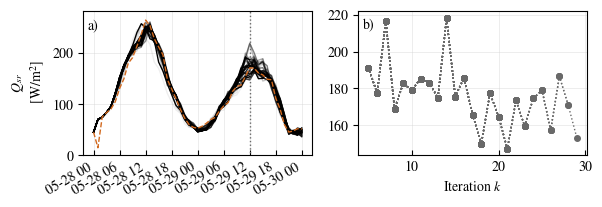

In [17]:
fig, axs = plt.subplots(nrows=1, ncols = 2, figsize = (6, 2), sharex = 'col', sharey = False)  # Adjust figsize as needed
   
# Plot temperature
ax = axs[0]


for i in range(len(alphas)):
    nemo_t = Qs_ice_A_grids_ece4[0][i]  # Assuming nemo_t_grids_ece4 is a list of xarray datasets
    if i == 0:
        nemo_t.plot(ax = ax, color=color_P, linestyle = linestyle_P, zorder=zorder_P)
    else:
        nemo_t.plot(
            ax = ax,  # Plotting sea surface temperature
            color=color,
            alpha=alphas[i],
        )

ax.set_ylabel(r" $Q_{sr}$" + f"\n [W/m$^2$]")

ax.set_xlabel(None)
ax.set_title(None)


color_oszi = ['dimgrey', 'darkgrey']
line_style = [':', "--"]

ax = axs[1]

for idx, var in enumerate(variables):

    dataset_group = datasets[idx]
    max_time = pd.to_datetime(max_range_times[var][0])
    iterations = []
    print(max_time)

    combined = None
    for i in range(len(alphas)):
        
        data = dataset_group[0][i]
        time_series = data.sel( time= max_time) 
            
        #print(time_series, time_series.values)
        iterations = np.append(iterations,time_series.values)
        ax.plot(range(len(iterations))[5:], iterations[5:], linestyle = line_style[d], color = 'dimgrey', 
                marker='o', label=f'{lon_lats[d]}, {max_time}')
    ax.set_xlabel(r'Iteration $k$')

    for i, ax in enumerate(axs.flatten()):
        ax.tick_params(axis='x', direction = 'in')  # Rotating x-axis labels
        ax.ticklabel_format(axis='y',useOffset=False)
        ax.text(0.02,.95,letterarray[i],transform=ax.transAxes,
                        ha='left',va='top')
    

# List of regular date strings
dates = [
    '2023-05-29 12:00:00'   
]

# Convert strings to datetime objects
datetime_objects = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in dates]
matplotlib_dates = [mdates.date2num(dt) for dt in datetime_objects]

axs[0].set_ylim(0,280)
axs[0].plot([matplotlib_dates[0],matplotlib_dates[0]], [-330,330], color='dimgrey', linestyle=':')

fig.subplots_adjust(hspace=0.02, wspace = 0.2)
fig.savefig(plotting_output_dir / "ece4_progvars_oifs_Qsr.pdf", bbox_inches='tight')